# Hashtag and Semantic Networks

In this notebook we generate some different bipartite networks on the subset of Bushfire tweets. We define actor nodes as being either Party or MP and document nodes as being either hashtags or words (unigrams).

In [97]:
#Necessary imports
import pandas as pd
import numpy as np
from tqdm import tqdm
import tweepy
from datetime import date
import pickle 
import time
from textnets import Corpus, Textnet
import matplotlib.pyplot as plt

## Preparing the Network

In [433]:
tweets = pd.read_csv("data/final_df.csv", index_col=0)

network_df = tweets[["screen_name", "party", "name", "hashtags", "pos_lemmas", "created_at"]]
#Subset bushfire tweets
network_df = network_df.loc[(network_df["pos_lemmas"].str.contains("burnt|burn|fire|Fire|black summer|bushfire|Bushfire|Bush fire|bush fire|bush-fire|Bush-fire")) & 
             (network_df["created_at"] > "2019-06-01") & (network_df["created_at"] < "2020-07-01")].reset_index(drop = True)

network_df["hashtags"] = network_df["hashtags"].apply(eval).apply(' '.join)
network_df["hashashtag"] = network_df["hashtags"].apply(lambda x: 1 if len(x) > 0 else 0)
network_df = network_df.loc[network_df["hashashtag"] == 1].reset_index(drop = True)

network_df = network_df.drop(columns=["hashashtag"])
network_df = (network_df.set_index(['screen_name', 'created_at',"party", "name", "pos_lemmas"])
       .apply(lambda x: x.str.split(' ').explode())
       .reset_index()) 

#Add hashtag symbol for better readability
network_df["hashtags"] = network_df["hashtags"].apply(lambda x: "#" + x)

#Create extra party attribute for plotting network
network_df["party2"] = network_df["party"]
#Upper case party and name for readability
#network_df["name"] = network_df["name"].apply(lambda x: str(x).upper())
#network_df["party"] = network_df["party"].apply(lambda x: str(x).upper())



## MP-Hashtag Network

In [396]:
#Prepare data for MP-Hashtag Network
mp_hashtag_df = network_df.set_index("name")
mp_hashtag_corpus = Corpus.from_df(mp_hashtag_df, doc_col='hashtags', lang='en')
tn_mp_hashtag = Textnet(mp_hashtag_corpus.tokenized(stem = False, lower=False, remove_punctuation = False,
                                                    remove_numbers = False, remove_stop_words = False,
                                                    remove_urls = False), 
                        min_docs=1, doc_attrs=mp_hashtag_df[['party']].to_dict())
hashtag = tn.project(node_type='term')

In [397]:
mp_hashtag_plot = tn_mp_hashtag.plot(label_term_nodes=True,
                            label_doc_nodes=True,
                            vertex_label_size = 6,
                            vertex_color=['gray' if v['party'] is None 
                                          else ('dodgerblue' if v['party'] == 'Liberal Party of Australia'
                                          else ('indianred' if v['party'] == 'Australian Labor Party' 
                                          else ('lightgreen' if v['party'] == 'Australian Greens' 
                                          else ('gold' if v['party'] == 'The Nationals' 
                                          else ('darkorange' if v['party'] == 'Center Alliance' 
                                          else ('pink' if v['party'] == 'Liberal National Party of Queensland'
                                          else  'purple'))))))
                                          for v in tn_mp_hashtag.vs],
                            vertex_shape=['none' if v['party'] is None 
                                          else 'triangle' if v['party'] == 'Liberal Party of Australia'
                                          else 'triangle-down'
                                          for v in tn_mp_hashtag.vs],
                            scale_nodes_by = 'degree')

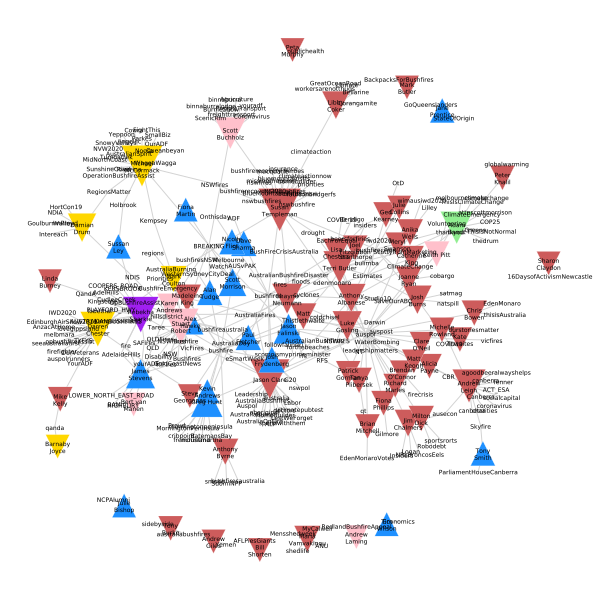

In [398]:
mp_hashtag_plot

In [399]:
print(tn.degree.sort_values(ascending=False)[:20].to_markdown())

|                   |   0 |
|:------------------|----:|
| Stuart Robert     |  65 |
| Michael McCormack |  43 |
| auspol            |  41 |
| bushfire          |  37 |
| Jason Clare       |  31 |
| Adam Bandt        |  26 |
| Rebekha Sharkie   |  25 |
| Susan Templeman   |  24 |
| Madeleine King    |  23 |
| Luke Gosling      |  22 |
| Darren Chester    |  20 |
| Anthony Albanese  |  19 |
| Josh Burns        |  18 |
| Andrew Leigh      |  16 |
| Terri Butler      |  16 |
| Scott Buchholz    |  15 |
| Joanne Ryan       |  13 |
| Greg Hunt         |  13 |
| Mark Coulton      |  12 |
| Damian Drum       |  11 |


## Party-Hashtag Network

In [400]:
#Prepare data for Party-Hashtag Network
party_hashtag_df = network_df.set_index("party2")
party_hashtag_corpus = Corpus.from_df(party_hashtag_df, doc_col='hashtags', lang='en')
tn_party_hashtag = Textnet(party_hashtag_corpus.tokenized(stem = False, lower=False, remove_punctuation = False,
                                                    remove_numbers = False, remove_stop_words = False,
                                                    remove_urls = False), min_docs=1, doc_attrs=party_hashtag_df[['party']].to_dict())

In [407]:
party_hashtag_plot = tn_party_hashtag.plot(label_term_nodes=True,
                                            label_doc_nodes=True,
                                            vertex_label_size=5,
                                            vertex_color=['lightgray' if v['party'] is None 
                                                          else ('dodgerblue' if v['party'] == 'Liberal Party of Australia'
                                                          else ('indianred' if v['party'] == 'Australian Labor Party' 
                                                          else ('lightgreen' if v['party'] == 'Australian Greens' 
                                                          else ('gold' if v['party'] == 'The Nationals' 
                                                          else ('darkorange' if v['party'] == 'Center Alliance' 
                                                          else ('pink' if v['party'] == 'Liberal National Party of Queensland'
                                                          else  'purple'))))))
                                                          for v in tn_party_hashtag.vs],
                                            vertex_shape=['none' if v['party'] is None 
                                                          else 'triangle' if v['party'] == 'Liberal Party of Australia'
                                                          else 'triangle-down'
                                                          for v in tn_party_hashtag.vs],
                                            scale_nodes_by = 'degree')

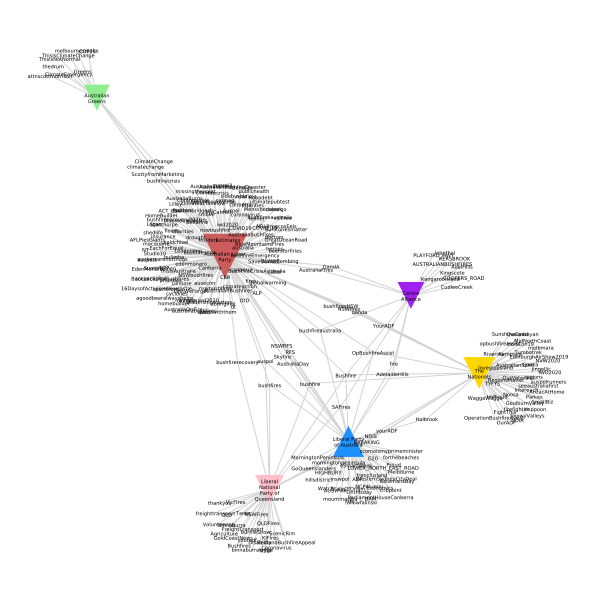

In [408]:
party_hashtag_plot

## Party-Semantic Network

In [349]:
party_semantic_df = network_df.set_index("party2")
party_semantic_corpus = Corpus.from_df(party_semantic_df, doc_col='pos_lemmas', lang='en')

In [415]:
tn_party_semantic = Textnet(party_semantic_corpus.tokenized(stem = False, lower=False, remove_punctuation = False,
                                                    remove_numbers = False, remove_stop_words = False,
                                                    remove_urls = False), min_docs=1, doc_attrs=party_semantic_df[['party']].to_dict())

In [479]:
plot_party_semantic = tn_party_semantic.plot(label_term_nodes=True,
                                              label_doc_nodes=True,
                                              vertex_label_size=4,
                                              alpha = 0.05,
                                              vertex_color=['gray' if v['party'] is None 
                                                              else ('dodgerblue' if v['party'] == 'Liberal Party of Australia'
                                                              else ('indianred' if v['party'] == 'Australian Labor Party' 
                                                              else ('lightgreen' if v['party'] == 'Australian Greens' 
                                                              else ('gold' if v['party'] == 'The Nationals' 
                                                              else ('darkorange' if v['party'] == 'Center Alliance' 
                                                              else ('pink' if v['party'] == 'Liberal National Party of Queensland'
                                                              else  'purple'))))))
                                                              for v in tn_party_semantic.vs],
                                               vertex_shape=['none' if v['party'] is None 
                                                              else 'triangle' if v['party'] == 'Liberal Party of Australia'
                                                              else 'triangle-down'
                                                              for v in tn_party_semantic.vs])

In [489]:
plot_party_semantic.save("network")

## MP-Semantic Network

In [481]:
mp_semantic_df = network_df.set_index("name")
mp_semantic_corpus = Corpus.from_df(mp_semantic_df, doc_col='pos_lemmas', lang='en')
tn_mp_semantic = Textnet(mp_semantic_corpus.tokenized(stem = False, lower=False, remove_punctuation = False,
                                                    remove_numbers = False, remove_stop_words = False,
                                                    remove_urls = False), min_docs=1, doc_attrs=mp_semantic_df[['party']].to_dict())
mps = tn_mp_semantic.project(node_type='doc')
#words = tn.project(node_type='term')

In [482]:
mp_semantic_plot = mps.plot(label_nodes=True,
                    vertex_label_size=5,
                    scale_nodes_by = "degree",
                    vertex_color=['gray' if v['party'] is None 
                                  else ('dodgerblue' if v['party'] == 'Liberal Party of Australia'
                                  else ('indianred' if v['party'] == 'Australian Labor Party' 
                                  else ('lightgreen' if v['party'] == 'Australian Greens' 
                                  else ('gold' if v['party'] == 'The Nationals' 
                                  else ('darkorange' if v['party'] == 'Center Alliance' 
                                  else ('pink' if v['party'] == 'Liberal National Party of Queensland'
                                  else  'purple'))))))
                                  for v in tn_mp_semantic.vs],
                    vertex_shape=['circle' if v['party'] is None 
                                  else 'triangle' if v['party'] == 'Liberal Party of Australia'
                                  else 'triangle-down'
                                  for v in tn_mp_semantic.vs],)

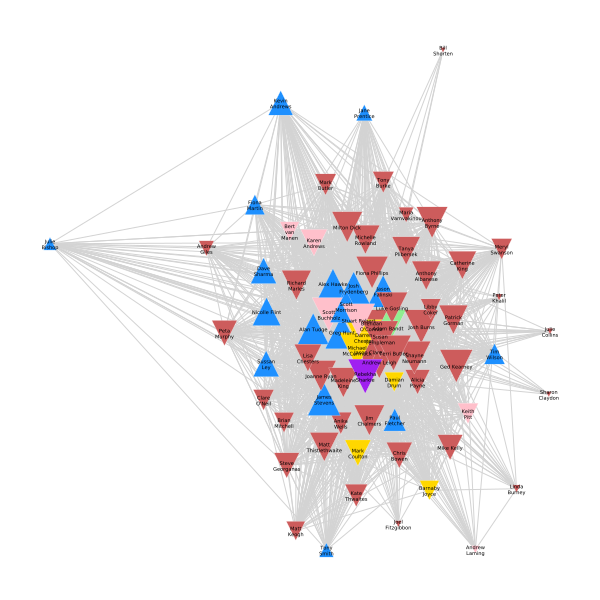

In [483]:
mp_semantic_plot

In [484]:
plot_mp_semantic = tn_mp_semantic.plot(label_term_nodes=True,
                                      label_doc_nodes=True,
                                      vertex_label_size=4,
                                      alpha = 0.05,
                                      vertex_color=['gray' if v['party'] is None 
                                                      else ('dodgerblue' if v['party'] == 'Liberal Party of Australia'
                                                      else ('indianred' if v['party'] == 'Australian Labor Party' 
                                                      else ('lightgreen' if v['party'] == 'Australian Greens' 
                                                      else ('gold' if v['party'] == 'The Nationals' 
                                                      else ('darkorange' if v['party'] == 'Center Alliance' 
                                                      else ('pink' if v['party'] == 'Liberal National Party of Queensland'
                                                      else  'purple'))))))
                                                      for v in tn_mp_semantic.vs],
                                       vertex_shape=['none' if v['party'] is None 
                                                      else 'triangle' if v['party'] == 'Liberal Party of Australia'
                                                      else 'triangle-down'
                                                      for v in tn_mp_semantic.vs])

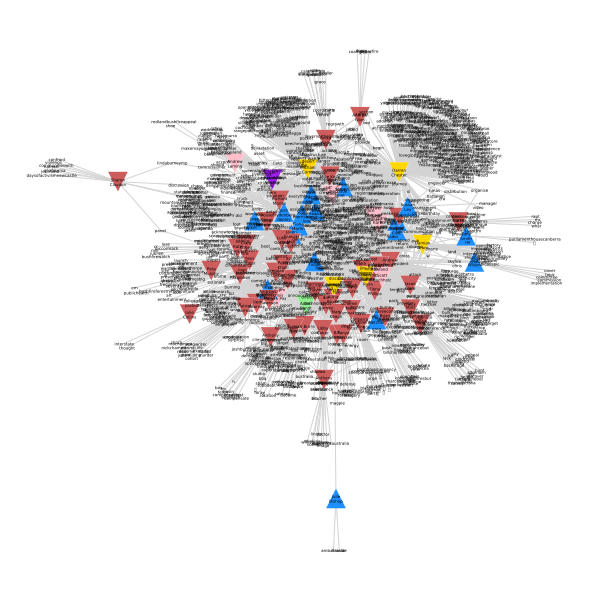

In [485]:
plot_mp_semantic

## Temporal Hashtag Network using pathpy


In [432]:
import pathpy as pp

In [461]:
network_df['start_date'] = pd.Timestamp('2019-06-03')
network_df["t"] = (pd.to_datetime(network_df["created_at"]) - pd.to_datetime(network_df["start_date"])).dt.days

In [467]:
pp_tuple = list(zip(network_df["name"], network_df["hashtags"], network_df["t"]))

In [471]:
t = pp.TemporalNetwork()
for link in pp_tuple:
    t.add_edge(link[0], link[1], link[2])